# Translitertion

## Loading dependences

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from IPython.display import clear_output

## Preprocessing and Data Loading

### lookup tables for vocabulary

In [52]:
SPECIAL_TOKENS = {
    '<PAD>': 0,     # Padding token - to equalize size of expressions
}


def lookup_table(vocabulary):
    vocabulary = set(list(vocabulary))
    v2i = copy.copy(SPECIAL_TOKENS)
    for i, vocab in enumerate(vocabulary, len(SPECIAL_TOKENS)):
        v2i[vocab] = i

    i2v = {i:v for v, i in v2i.items()}
    return v2i, i2v

ENG = 'abcdefghijklmnopqrstuvwxyz'
HIN = ''.join(c for c in [chr(alpha) for alpha in range(2304, 2432)])

hin_v2i, hin_i2v = lookup_table(HIN)
eng_v2i, eng_i2v = lookup_table(ENG)

In [53]:
print(eng_v2i)

{'<PAD>': 0, 'l': 1, 'm': 2, 'q': 3, 'u': 4, 'j': 5, 'y': 6, 'v': 7, 'h': 8, 'r': 9, 'w': 10, 'n': 11, 'g': 12, 'f': 13, 'c': 14, 'o': 15, 'd': 16, 't': 17, 's': 18, 'a': 19, 'z': 20, 'p': 21, 'x': 22, 'k': 23, 'e': 24, 'b': 25, 'i': 26}


In [54]:
print(hin_v2i)

{'<PAD>': 0, 'ऻ': 1, 'ु': 2, 'ॱ': 3, 'ॡ': 4, 'च': 5, 'ङ': 6, '५': 7, 'ॺ': 8, 'स': 9, 'ळ': 10, 'ग': 11, 'ड': 12, 'भ': 13, 'ओ': 14, 'व': 15, 'क़': 16, 'ॷ': 17, 'ऱ': 18, 'ष': 19, 'ॅ': 20, 'ॊ': 21, '।': 22, 'अ': 23, 'झ': 24, '६': 25, 'ज़': 26, 'ॲ': 27, 'ऐ': 28, 'ि': 29, 'ॿ': 30, 'ए': 31, 'ऑ': 32, 'ं': 33, '७': 34, 'ॵ': 35, 'ॼ': 36, 'र': 37, '्': 38, 'श': 39, 'ॖ': 40, '९': 41, 'ट': 42, 'क': 43, 'द': 44, 'ध': 45, 'ॆ': 46, 'घ': 47, 'ऀ': 48, 'फ': 49, 'ठ': 50, '२': 51, 'य': 52, 'म': 53, 'ब': 54, 'ॉ': 55, '॓': 56, 'ै': 57, 'ऩ': 58, 'ी': 59, 'ॐ': 60, '॥': 61, 'ऊ': 62, 'ऴ': 63, 'थ': 64, 'ऌ': 65, 'ॠ': 66, 'ढ': 67, 'ो': 68, 'ऎ': 69, 'ऺ': 70, 'ई': 71, 'ः': 72, '़': 73, 'ॄ': 74, 'ॗ': 75, '४': 76, '॔': 77, 'ञ': 78, 'ऒ': 79, 'ढ़': 80, 'इ': 81, 'न': 82, '॑': 83, 'े': 84, 'य़': 85, 'ऍ': 86, 'ॳ': 87, 'ौ': 88, 'ॻ': 89, 'ड़': 90, 'ॸ': 91, 'ॏ': 92, 'ॕ': 93, 'ऽ': 94, 'ग़': 95, 'त': 96, '३': 97, 'ॽ': 98, 'ॾ': 99, 'छ': 100, 'ल': 101, 'ण': 102, 'उ': 103, 'ह': 104, 'ॶ': 105, 'ऋ': 106, 'ॹ': 107, '॰': 108, 'ख़': 109, 'ख': 

### Loading Dataset

In [55]:
dataset = pd.read_csv('transliteration.txt', delimiter='\t', encoding='utf-8', na_filter=False, header=None)
print(dataset.shape)
ENG_WORDS = dataset.iloc[:, 0].to_numpy()
HIN_WORDS = dataset.iloc[:, 1].to_numpy()

(30823, 2)


In [56]:
print(ENG_WORDS[1], HIN_WORDS[1])

khushbuu खुशबू


In [57]:
ENG_TRAIN, ENG_TEST, HIN_TRAIN, HIN_TEST = train_test_split( ENG_WORDS,HIN_WORDS,  test_size=0.20)
print(len(HIN_TRAIN), len(HIN_TEST))

24658 6165


### DataLoader

In [58]:
class DataLoader(Dataset):
  def __init__(self, hindi , english):
    self.eng_words = english
    self.hin_words = hindi
    self.shuffle_indices = list(range(len(self.hin_words)))
    self.shuffle_start_idx = 0
    random.shuffle(self.shuffle_indices)

  def __len__(self):
    return len(self.eng_words)

  def __getitem__(self, idx):
    return self.eng_words[idx], self.hin_words[idx]

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.eng_words)))

  def get_array_batch(self, BATCH_SIZE, arr):
    end = self.shuffle_start_idx + BATCH_SIZE
    batch = []
    if end >= len(self.eng_words):
      
      batch = [arr[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
      end = len(self.eng_words)
    return batch + [arr[i] for i in self.shuffle_indices[self.shuffle_start_idx : end]]

  def get_batches(self, BATCH_SIZE):
    hin_batch = self.get_array_batch(BATCH_SIZE, self.hin_words)
    eng_batch = self.get_array_batch(BATCH_SIZE, self.eng_words)
    self.shuffle_start_idx += BATCH_SIZE + 1

    # Reshuffle
    if self.shuffle_start_idx >= len(self.eng_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_idx = 0

    return eng_batch , hin_batch


In [59]:
train_data = DataLoader(HIN_TRAIN , ENG_TRAIN)
test_data = DataLoader(HIN_TEST , ENG_TEST)

In [60]:
HIN_TEST
ENG_TEST

array(['choomta', 'guaalaa', 'gote', ..., 'antadiyon', 'banho', 'baite'],
      dtype=object)

### Word encoding

In [61]:
def hindi_encoding(word, v2i, device='cpu'):
  rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0] = pos
  rep[i+1][0] = v2i['<PAD>']
  return rep


In [62]:
def eng_encoding(word, v2i, device='cpu'):
  rep = torch.zeros(len(word)+1, 1, len(v2i)).to(device)
  for i, char in enumerate(word):
    pos = v2i[char]
    rep[i][0][pos] = 1

  pad_pos = v2i['<PAD>']
  rep[i+1][0][pad_pos] = 1
  return rep


In [63]:
eng , hindi = train_data.get_random_sample()

In [64]:
print(hindi, hindi_encoding(hindi, hin_v2i))

नसीम tensor([[82],
        [ 9],
        [59],
        [53],
        [ 0]])


In [65]:
hindi_encoding(hindi, hin_v2i).shape

torch.Size([5, 1])

In [66]:
print(eng , eng_encoding(eng, eng_v2i))

nasim tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [67]:
eng_encoding(eng, eng_v2i).shape

torch.Size([6, 1, 27])

## Model: Encoder decoder with Attention

In [68]:
class Encoder_Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(Encoder_Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.encoder_rnn = nn.GRU(input_size, hidden_size)
    self.decoder_rnn = nn.GRU(hidden_size*2, hidden_size)
    self.hidden_to_output = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    self.U = nn.Linear(self.hidden_size, self.hidden_size)
    self.W = nn.Linear(self.hidden_size, self.hidden_size)
    self.attention = nn.Linear(self.hidden_size, 1)
    self.output_to_hidden = nn.Linear(self.output_size, self.hidden_size)
    self.verbose = verbose


  def forward(self, input, max_output_chars = 30, device='cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attention(torch.tanh(U + W))
            attention_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attention', attention_weights.shape)
            
            attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.output_to_hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attention_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attention LC', attention_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn(decoder_input, decoder_state)
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.hidden_to_output(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [69]:
enc_dec = Encoder_Decoder( len(eng_v2i),256, len(hin_v2i), True)

In [70]:
enc_dec.get_parameter

<bound method Module.get_parameter of Encoder_Decoder(
  (encoder_rnn): GRU(27, 256)
  (decoder_rnn): GRU(512, 256)
  (hidden_to_output): Linear(in_features=256, out_features=129, bias=True)
  (softmax): LogSoftmax(dim=2)
  (U): Linear(in_features=256, out_features=256, bias=True)
  (W): Linear(in_features=256, out_features=256, bias=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (output_to_hidden): Linear(in_features=129, out_features=256, bias=True)
)>

In [71]:
sum([param.nelement() for param in enc_dec.parameters()])

1008514

## Training

In [72]:
def train(model, optimizer, criterion, BATCH_SIZE, device='cpu', force=False):
  model.train().to(device)
  optimizer.zero_grad()
  eng_batch , hin_batch = train_data.get_batches(BATCH_SIZE)
  total_loss = 0
  for i in range(BATCH_SIZE):
    
    input_ = eng_encoding(eng_batch[i], eng_v2i, device)
    hind_ = hindi_encoding(hin_batch[i], hin_v2i, device)
    
    
    
    outputs = model.forward(input_, hind_.shape[0], device, ground_truth=hind_ if force else None)
    for i, output in enumerate(outputs):
      loss = criterion(output, hind_[i]) / BATCH_SIZE
      loss.backward(retain_graph=True)
      total_loss += loss

  optimizer.step()
  return total_loss / BATCH_SIZE


In [73]:
def setup(model, LEARNING_RATE=0.01, NUM_BATCHES=10, BATCH_SIZE=10, DISPLAY_STEP=5, device='cpu', e=256):
   model = model.to(device)
   criterion = nn.NLLLoss(ignore_index=-1)
   optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
   force_upto = NUM_BATCHES // 3
   loss_arr = np.zeros(NUM_BATCHES+1)

   for i in range(NUM_BATCHES):
     loss_arr[i+1] = (loss_arr[i]*i + train(model, optimizer, criterion, BATCH_SIZE, device=device, force=i<force_upto))/(i+1)

     if i % DISPLAY_STEP == DISPLAY_STEP-1:
       clear_output(wait=True)
       print('Iteration', i, 'Loss', loss_arr[i])
       plt.figure(figsize=(12,6))
       plt.plot(loss_arr[1:i])
       plt.xlabel('Iterations')
       plt.ylabel('Loss')
       plt.show()

   return loss_arr

In [74]:
enc_dec = Encoder_Decoder(len(eng_v2i) ,256 ,  len(hin_v2i) )

Iteration 299 Loss 0.12240982055664062


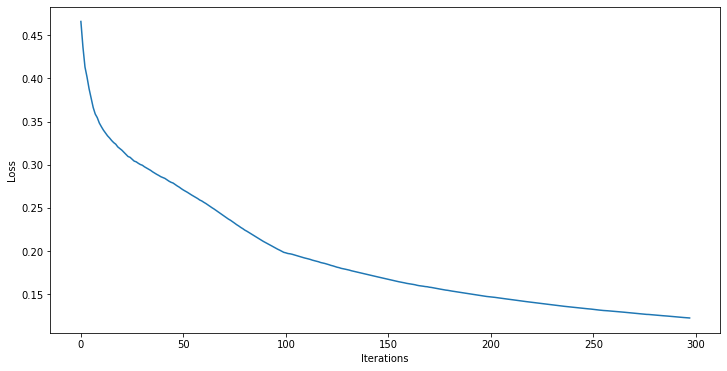

In [75]:
loss = setup(enc_dec, LEARNING_RATE=0.01, NUM_BATCHES=300, BATCH_SIZE=64, DISPLAY_STEP=10, e=256)

## Save model

In [76]:
torch.save(enc_dec ,  f'model1__lr_0.01_nb=300_bs=64_e=256.pt')

### Accuracy

In [77]:
def accuracy(model, device='cpu'):
  model = model.eval().to(device)
  preds = []
  acc = 0
  for i in range(len(test_data)):
    english, hindi = test_data[i]
    
    hind_ = hindi_encoding(hindi, hin_v2i, device)

    
    outputs = get_output(model, english, hind_.shape[0], device)
    
    predicted_correctly = 0
    for i, output in enumerate(outputs):
      values, indices = output.topk(1)
      hind_pos = indices.tolist()[0]
        
      if hind_pos[0] == hind_[i][0]:
        predicted_correctly += 1

    acc += predicted_correctly / hind_.shape[0]
  acc /= len(test_data)
  return acc

In [78]:
def get_output(model, word, max_output_chars=30, device='cpu'):
  out = model.forward(eng_encoding(word, eng_v2i), max_output_chars=max_output_chars, device=device)
  return out

### loading model

In [79]:
m1 = torch.load('model1__lr_0.01_nb=300_bs=64_e=256.pt')
print("Accuracy:", accuracy(m1)*100)

Accuracy: 79.13928839476316


### Sample Test

In [80]:
def test(model, word, device='cpu'):
  model = model.eval().to(device)
  outputs = get_output(model, word, 30, device)
  hin_output = ''
  for output in outputs:
    values, indices = output.topk(1)
    idx = indices.tolist()[0][0]
    if idx == 0: # <PAD>
      break
    char = hin_i2v[idx]
    hin_output += char
  print(word, '->', hin_output)
  return hin_output

### prediction

In [81]:
hindi_out = test(m1, eng)
print("Actual:", eng, "\nPredicted:", hindi_out)

nasim -> नसीम
Actual: nasim 
Predicted: नसीम


### Sample Prediction

In [82]:
trial_output = get_output(enc_dec, eng)

In [83]:
print('Output Length:', len(trial_output))

Output Length: 30


In [84]:
for i in range(len(trial_output)):
  print(trial_output[i].shape, list(hin_v2i.keys())[list(hin_v2i.values()).index(torch.argmax(trial_output[i]))])

torch.Size([1, 129]) न
torch.Size([1, 129]) स
torch.Size([1, 129]) ी
torch.Size([1, 129]) म
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>
torch.Size([1, 129]) <PAD>


In [85]:
print(hindi, eng)


नसीम nasim
